## MargFormer - Experiment2 - Star-Galaxy-Quasar Classification

## Star-Galaxy-Quasar Classification (Experiment 2) using Vision Transformer (ViT, Linformer) Model with CLS token derived uisng the Photometric Features. Query is defined using only photometry data in the Cross-Attention.

#### Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
np.random.seed(69)
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns
sns.set()
# from tqdm.notebook 
import tqdm
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import time
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from linformer import LinformerCA, Linformer
from vit_pytorch.efficient_new import ViT


#### 1. Load and extract the dataset

In [2]:
X = np.load("/scratch/srinadb/Foundation/Dataset/Experiment2/X_exp2.npy")
dnnx = np.load("/scratch/srinadb/Foundation//Dataset/Experiment2/dnnx_exp2.npy")
objlist = np.load("/scratch/srinadb/Foundation//Dataset/Experiment2/objlist_exp2.npy")
y = np.load("/scratch/srinadb/Foundation//Dataset/Experiment2/y_exp2.npy", allow_pickle=True)

# idx_drop = np.where(y=="QSO")[0]
# X = np.delete(X,idx_drop,axis=0)
# dnnx = np.delete(dnnx,idx_drop,axis=0)
# y = np.delete(y,idx_drop,axis=0)
# objlist = np.delete(objlist,idx_drop,axis=0)
y, label_strings = pd.factorize(y,sort=True)
# y = to_categorical(y)
print('\n')
print(label_strings)




['GALAXY' 'QSO' 'STAR']


In [3]:
zipX = list(zip(X, dnnx))
zipy = list(zip(y, objlist))

zipX_train, zipX_test, zipy_train, zipy_test = train_test_split(zipX, zipy, test_size = 0.1,random_state=42)
zipX_train, zipX_val, zipy_train, zipy_val = train_test_split(zipX_train, zipy_train, test_size = 0.1111111, random_state=42)

X_train, dnnx_train = zip(*zipX_train)
X_val, dnnx_val = zip(*zipX_val)
X_test, dnnx_test = zip(*zipX_test)

y_train, objlist_train = zip(*zipy_train)
y_val, objlist_val = zip(*zipy_val)
y_test, objlist_test = zip(*zipy_test)

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

dnnx_train = np.array(dnnx_train)
dnnx_val = np.array(dnnx_val)
dnnx_test = np.array(dnnx_test)

y_train = np.array(y_train)
objlist_train = np.array(objlist_train)
y_val = np.array(y_val)
objlist_val = np.array(objlist_val)
y_test = np.array(y_test)
objlist_test = np.array(objlist_test)

del(zipX,zipX_test,zipX_train,zipX_val, X, zipy, zipy_test, zipy_train, zipy_val, objlist)

X_train = X_train.transpose((0, 3, 1, 2))
X_val = X_val.transpose((0, 3, 1, 2))
X_test = X_test.transpose((0, 3, 1, 2))

print('\n')
print('The shape of the Train data is:', X_train.shape)
print('The shape of the Validation data is:', X_val.shape)
print('The shape of the Test data is:', X_test.shape)




The shape of the Train data is: (119996, 5, 32, 32)
The shape of the Validation data is: (15000, 5, 32, 32)
The shape of the Test data is: (15000, 5, 32, 32)


In [4]:
def get_metrics(y_pred, y_test, labels, to_print=True):
    correct_labels = np.where(y_pred==y_test)[0]
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred,average='macro')
    recall = metrics.recall_score(y_test, y_pred,average='macro')
    f1score = metrics.f1_score(y_test, y_pred,average='macro')
    # rocscore = metrics.roc_auc_score(y_test, y_pred,average='micro',multi_class="ovo")
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)  
    classification_report = metrics.classification_report(y_test, y_pred)

    if to_print:
        print("Identified {} correct labels out of {} labels".format(len(correct_labels), y_test.shape[0]))
        print("Accuracy:",accuracy)
        print("Precision:",precision)
        print("Recall:",recall)
        print("F1 Score:",f1score)
        # print("ROC AUC Score:",rocscore)
        print(f"Labels are: {labels}")
        print("Confusion Matrix:\n", confusion_matrix)
        print("Classification_Report:\n", classification_report)

    return (correct_labels, accuracy, precision, recall, confusion_matrix, classification_report)


##### Create dataset and dataloader for pytorch training

In [5]:
class SGData(Dataset):
    def __init__(self, x1, x2, y, transform=None):
        self.n_samples = x2.shape[0]
        self.x1 = torch.tensor(x1, dtype=torch.float32)
        self.x2 = torch.tensor(x2, dtype=torch.float32)
        self.y = torch.tensor(y)
        self.transform = transform

    def __len__(self):
        return self.n_samples

    def __getitem__(self, i):
        inputs_pf, inputs_imgs, targets = self.x1[i], self.x2[i], self.y[i]
        
        if self.transform:
            inputs_pf = inputs_pf
            inputs_imgs = self.transform(inputs_imgs)

        return inputs_pf, inputs_imgs, targets

# Define your data augmentation transformations
image_transform = transforms.Compose([    
    transforms.RandomRotation(180),
    transforms.RandomAffine(degrees = 0, translate = (0.1, 0.1)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])

# Create DataLoader for training and validation data
train_dataset = SGData(dnnx_train, X_train, y_train, transform=image_transform)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=8)
val_dataset = SGData(dnnx_val, X_val, y_val, transform=image_transform)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False, num_workers=4)
test_dataset = SGData(dnnx_test, X_test, y_test, transform=None)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=4)


#### 2. Initialize or Define the Model

In [6]:
# Initialize the PyTorch model
n_classes = 3
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
in_channels = X_train.shape[1]

PATCH_SIZE = 4
DEPTH = 12
HIDDEN_DIM = 64
K_DIM = 64
NUM_HEADS = 8

LR = 1e-3
STEP_SIZE = 5
GAMMA = 0.9

LIN_DROPOUT = 0.1

seq_len = int((32/PATCH_SIZE)**2) + 1

## Linformer
lin = LinformerCA(dim=HIDDEN_DIM, seq_len=seq_len, depth=DEPTH, k=K_DIM, heads=NUM_HEADS,
                dim_head=None, one_kv_head=False, share_kv=False, reversible=False, dropout=LIN_DROPOUT)

## Vision Transformer
model = ViT(image_size=32, patch_size=PATCH_SIZE, num_classes=n_classes, dim=HIDDEN_DIM, transformer=lin, pool='cls', channels=in_channels).to(device)


cuda:0


#### 3. Training the model



Epoch [1/300] - Train Loss: 0.8129, Train Accuracy: 0.5971, Validation Loss: 0.5582, Validation Accuracy: 0.7466
Epoch [2/300] - Train Loss: 0.5319, Train Accuracy: 0.7643, Validation Loss: 0.4932, Validation Accuracy: 0.7827
Epoch [3/300] - Train Loss: 0.4739, Train Accuracy: 0.7949, Validation Loss: 0.4465, Validation Accuracy: 0.8100
Epoch [4/300] - Train Loss: 0.4471, Train Accuracy: 0.8070, Validation Loss: 0.4355, Validation Accuracy: 0.8191
Epoch [5/300] - Train Loss: 0.4281, Train Accuracy: 0.8181, Validation Loss: 0.4135, Validation Accuracy: 0.8221
Epoch [6/300] - Train Loss: 0.4166, Train Accuracy: 0.8235, Validation Loss: 0.4063, Validation Accuracy: 0.8260
Epoch [7/300] - Train Loss: 0.4055, Train Accuracy: 0.8290, Validation Loss: 0.3892, Validation Accuracy: 0.8331
Epoch [8/300] - Train Loss: 0.3966, Train Accuracy: 0.8322, Validation Loss: 0.4080, Validation Accuracy: 0.8227
Epoch [9/300] - Train Loss: 0.3904, Train Accuracy: 0.8347, Validation Loss: 0.3956, Validatio

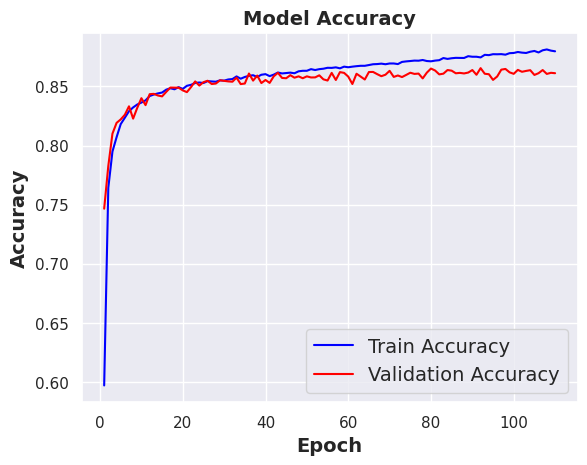

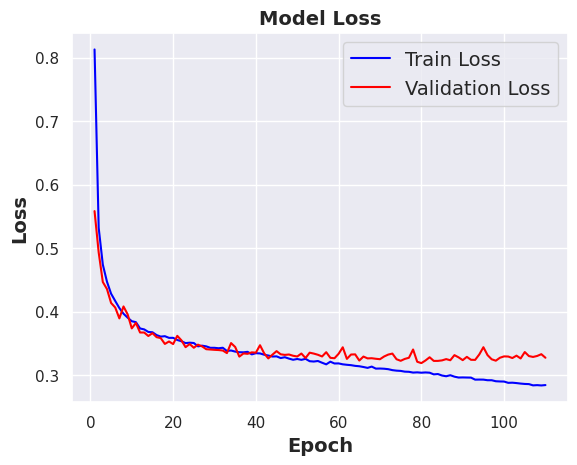

In [7]:
train_loss_arr = []
train_accuracy_arr = []
val_loss_arr = []
val_accuracy_arr = []

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Early stopping parameters
patience = 30
best_val_loss = float('inf')
best_model_state = None  # Initialize a variable to store the best model state
counter = 0

# Training loop
epochs = 300
epoch1 =0
print('\n')
for epoch in range(epochs):
    epoch1+=1
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for batch_x1, batch_x2, batch_y in train_loader:
        batch_x1 = batch_x1.to(device)
        batch_x2 = batch_x2.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_x1, batch_x2)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = output.max(1)
        total_train += batch_y.size(0)
        correct_train += predicted.eq(batch_y).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = correct_train / total_train
    train_loss_arr.append(train_loss)
    train_accuracy_arr.append(train_accuracy)
    
    model.eval()
    
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for batch_x1, batch_x2, batch_y in val_loader:
            batch_x1 = batch_x1.to(device)
            batch_x2 = batch_x2.to(device)
            batch_y = batch_y.to(device)
            output = model(batch_x1, batch_x2)
            val_loss += criterion(output, batch_y).item()
            _, predicted = output.max(1)
            total_val += batch_y.size(0)
            correct_val += predicted.eq(batch_y).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct_val / total_val
    val_loss_arr.append(val_loss)
    val_accuracy_arr.append(val_accuracy)
    
    model.train()
        
    #Check for early stopping and save best model state
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        best_model_state = model.state_dict()  # Store the current best model state
        torch.save(best_model_state, "Trained_Models/Experiment2/SGQ/EX2_SGQ_MargFormer_Model.pth")
    else:
        counter += 1

    if counter >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        if best_model_state is not None:
            model.load_state_dict(best_model_state)  # Restore best model state
        counter = 0  # Reset the counter    
        break

    print(f'Epoch [{epoch+1}/{epochs}] - '
      f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
      f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

# Create the range of epochs
epoch_range = range(1, epoch1+1)

# Plot training accuracy in blue
plt.figsize=(8, 6)  # Adjust the size as needed
plt.plot(epoch_range, train_accuracy_arr, label='Train Accuracy', color='blue')

# Plot validation accuracy in red
plt.plot(epoch_range, val_accuracy_arr, label='Validation Accuracy', color='red')

# Add labels and title
plt.xlabel('Epoch', fontsize=14, weight='bold')
plt.ylabel('Accuracy', fontsize=14, weight='bold')
plt.title('Model Accuracy', fontsize=14, weight='bold')

# Add a legend
plt.legend(fontsize=14, title_fontproperties={'weight':'bold'})
plt.savefig("Trained_Models/Experiment2/SGQ/EX2_SGQ_MargFormer_Accuracy.png")
# Show the plot
plt.show()
plt.close()

# Plot training accuracy in blue
plt.figsize=(8, 6)  # Adjust the size as needed
plt.plot(epoch_range, train_loss_arr, label='Train Loss', color='blue')

# Plot validation accuracy in red
plt.plot(epoch_range, val_loss_arr, label='Validation Loss', color='red')

# Add labels and title
plt.xlabel('Epoch', fontsize=14, weight='bold')
plt.ylabel('Loss', fontsize=14, weight='bold')
plt.title('Model Loss', fontsize=14, weight='bold')

# Add a legend
plt.legend(fontsize=14, title_fontproperties={'weight':'bold'})
plt.savefig("Trained_Models/Experiment2/SGQ/EX2_SGQ_MargFormer_Loss.png")
# Show the plot
plt.show()
plt.close()


#### 4. Testing the Model

In [2]:
torch.cuda.empty_cache()

# Set the model to evaluation mode
model.load_state_dict(torch.load('./Trained_Models/Experiment2/SGQ/EX2_SGQ_MargFormer_Model.pth', map_location=device))

model.eval()
y_test_pred = torch.empty(0).to(device)
print('\n')
# Generate predictions
with torch.no_grad():
    for pf, images, labels in test_loader:
        pf = pf.to(device)
        images = images.to(device)
        labels = labels.to(device)
        pred = model(pf, images)

        y_test_pred = F.softmax(torch.cat((y_test_pred, pred), dim=0))

y_test_pred = y_test_pred.cpu().numpy()
y_test_pred = y_test_pred.argmax(axis=1)
print(get_metrics(y_test_pred, y_test, label_strings))

# https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/#google_vignette
# fig = plt.figure()
cf_matrix = metrics.confusion_matrix(y_test, y_test_pred)
cf_matrix_percentage = metrics.confusion_matrix(y_test, y_test_pred, normalize='true')
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix_percentage.flatten()]
labels = [f"{v1}\n({v2})\n" for v1, v2 in
          zip(group_percentages,group_counts)]
labels = np.asarray(labels).reshape(3,3)
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust the size as needed

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_xlabel('\nPredicted', fontsize=14, weight='bold')
ax.set_ylabel('Actual', fontsize=14, weight='bold');
ax.xaxis.set_ticklabels(['GALAXY', 'QSO', 'STAR'], fontsize=14, weight='bold')
ax.yaxis.set_ticklabels(['GALAXY', 'QSO', 'STAR'], fontsize=14, weight='bold')
plt.tight_layout()
plt.savefig("Trained_Models/Experiment2/SGQ/EX2_SGQ_MargFormer_CM.png")
plt.show()
plt.close()

NameError: name 'model' is not defined

In [9]:
sum(p.numel() for p in model.parameters())


1405475

## Result Analysis

In [10]:
X = np.load("/scratch/srinadb/Foundation/Dataset/Experiment2/X_exp2.npy")
dnnx = np.load("/scratch/srinadb/Foundation//Dataset/Experiment2/dnnx_exp2.npy")
objlist = np.load("/scratch/srinadb/Foundation//Dataset/Experiment2/objlist_exp2.npy")
y = np.load("/scratch/srinadb/Foundation//Dataset/Experiment2/y_exp2.npy", allow_pickle=True)

y, label_strings = pd.factorize(y,sort=True)
# y = to_categorical(y)
print('\n')
print(label_strings)

zipX = list(zip(X, dnnx))
zipy = list(zip(y, objlist))

zipX_train, zipX_test, zipy_train, zipy_test = train_test_split(zipX, zipy, test_size = 0.1,random_state=42)
zipX_train, zipX_val, zipy_train, zipy_val = train_test_split(zipX_train, zipy_train, test_size = 0.1111111, random_state=42)

X_train, dnnx_train = zip(*zipX_train)
X_val, dnnx_val = zip(*zipX_val)
X_test, dnnx_test = zip(*zipX_test)

y_train, objlist_train = zip(*zipy_train)
y_val, objlist_val = zip(*zipy_val)
y_test, objlist_test = zip(*zipy_test)

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

dnnx_train = np.array(dnnx_train)
dnnx_val = np.array(dnnx_val)
dnnx_test = np.array(dnnx_test)

y_train = np.array(y_train)
objlist_train = np.array(objlist_train)
y_val = np.array(y_val)
objlist_val = np.array(objlist_val)
y_test = np.array(y_test)
objlist_test = np.array(objlist_test)

del(zipX,zipX_test,zipX_train,zipX_val, X, zipy, zipy_test, zipy_train, zipy_val, objlist)

X_train = X_train.transpose((0, 3, 1, 2))
X_val = X_val.transpose((0, 3, 1, 2))
X_test = X_test.transpose((0, 3, 1, 2))

print('\n')
print('The shape of the Train data is:', X_train.shape)
print('The shape of the Validation data is:', X_val.shape)
print('The shape of the Test data is:', X_test.shape)

class SGData(Dataset):
    def __init__(self, x1, x2, y, transform=None):
        self.n_samples = x2.shape[0]
        self.x1 = torch.tensor(x1, dtype=torch.float32)
        self.x2 = torch.tensor(x2, dtype=torch.float32)
        self.y = torch.tensor(y)
        self.transform = transform

    def __len__(self):
        return self.n_samples

    def __getitem__(self, i):
        inputs_pf, inputs_imgs, targets = self.x1[i], self.x2[i], self.y[i]
        
        if self.transform:
            inputs_pf = inputs_pf
            inputs_imgs = self.transform(inputs_imgs)

        return inputs_pf, inputs_imgs, targets

# Define your data augmentation transformations
image_transform = transforms.Compose([    
    transforms.RandomRotation(180),
    transforms.RandomAffine(degrees = 0, translate = (0.1, 0.1)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])

# Create DataLoader for training and validation data
train_dataset = SGData(dnnx_train, X_train, y_train, transform=None)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=False, num_workers=8)
val_dataset = SGData(dnnx_val, X_val, y_val, transform=None)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False, num_workers=4)
test_dataset = SGData(dnnx_test, X_test, y_test, transform=None)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=4)




['GALAXY' 'QSO' 'STAR']


The shape of the Train data is: (119996, 5, 32, 32)
The shape of the Validation data is: (15000, 5, 32, 32)
The shape of the Test data is: (15000, 5, 32, 32)


In [11]:
model.load_state_dict(torch.load('./Trained_Models/Experiment2/SGQ/EX2_SGQ_MargFormer_Model.pth', map_location=device))

def get_preds(loader):
    model.eval()
    all_preds = []

    with torch.no_grad():
        for pf, images, labels in loader:
            pf = pf.to(device)
            images = images.to(device)
            pred = model(pf, images)
            all_preds.append(pred.cpu())

    all_preds = torch.cat(all_preds, dim=0).numpy()
    pred_labels = all_preds.argmax(axis=1)
    return all_preds, pred_labels

preds_train, y_train_pred = get_preds(train_loader)
print(get_metrics(y_train_pred, y_train, label_strings))
print('\n')
preds_val, y_val_pred = get_preds(val_loader)
print(get_metrics(y_val_pred, y_val, label_strings))
print('\n')
preds_test, y_test_pred = get_preds(test_loader)
print(get_metrics(y_test_pred, y_test, label_strings))


Identified 106338 correct labels out of 119996 labels
Accuracy: 0.8861795393179772
Precision: 0.8863746114532712
Recall: 0.8860674996499305
F1 Score: 0.8861406458606277
Labels are: ['GALAXY' 'QSO' 'STAR']
Confusion Matrix:
 [[38131  1388   615]
 [ 1274 34302  4416]
 [  699  5266 33905]]
Classification_Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95     40134
           1       0.84      0.86      0.85     39992
           2       0.87      0.85      0.86     39870

    accuracy                           0.89    119996
   macro avg       0.89      0.89      0.89    119996
weighted avg       0.89      0.89      0.89    119996

(array([     0,      1,      2, ..., 119992, 119993, 119994]), 0.8861795393179772, 0.8863746114532712, 0.8860674996499305, array([[38131,  1388,   615],
       [ 1274, 34302,  4416],
       [  699,  5266, 33905]]), '              precision    recall  f1-score   support\n\n           0       0.95      0.95 

In [12]:
df = pd.read_csv("/scratch/srinadb/Foundation/Dataset/Experiment2/photofeatures_exp2.csv",index_col=0)

df.loc[objlist_train, ["set"]] = "TRAIN"
df.loc[objlist_val, ["set"]] = "VALIDATION"
df.loc[objlist_test, ["set"]] = "TEST"

df.loc[objlist_train, ["pred_class"]] = label_strings[preds_train.argmax(axis=1)]
df.loc[objlist_val, ["pred_class"]] = label_strings[preds_val.argmax(axis=1)]
df.loc[objlist_test, ["pred_class"]] = label_strings[preds_test.argmax(axis=1)]

pgal_train = preds_train[:,np.where(label_strings=="GALAXY")[0][0]]
pstar_train = preds_train[:,np.where(label_strings=="STAR")[0][0]]
pqso_train = preds_train[:,np.where(label_strings=="QSO")[0][0]]

pgal_val = preds_val[:,np.where(label_strings=="GALAXY")[0][0]]
pstar_val = preds_val[:,np.where(label_strings=="STAR")[0][0]]
pqso_val = preds_val[:,np.where(label_strings=="QSO")[0][0]]

pgal_test = preds_test[:,np.where(label_strings=="GALAXY")[0][0]]
pstar_test = preds_test[:,np.where(label_strings=="STAR")[0][0]]
pqso_test = preds_test[:,np.where(label_strings=="QSO")[0][0]]


df.loc[objlist_train, ["prob_gal"]] = pgal_train
df.loc[objlist_train, ["prob_star"]] = pstar_train
df.loc[objlist_train, ["prob_qso"]] = pqso_train

df.loc[objlist_val, ["prob_gal"]] = pgal_val
df.loc[objlist_val, ["prob_star"]] = pstar_val
df.loc[objlist_val, ["prob_qso"]] = pqso_val

df.loc[objlist_test, ["prob_gal"]] = pgal_test
df.loc[objlist_test, ["prob_star"]] = pstar_test
df.loc[objlist_test, ["prob_qso"]] = pqso_test
df.to_csv("Trained_Models/Experiment2/SGQ/EX2_SGQ_MargFormer_results_exp2.csv")


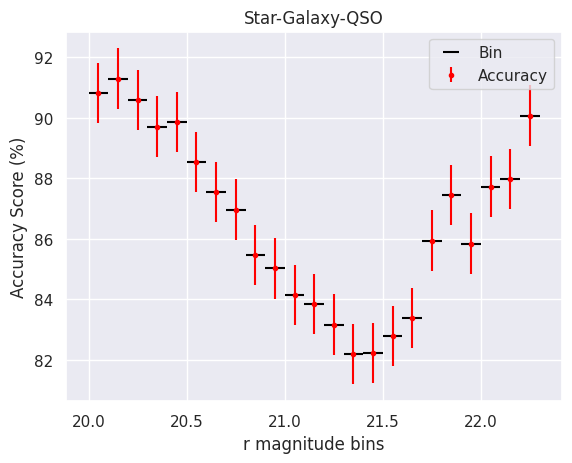

In [13]:
sns.set_palette("tab10")
df = pd.read_csv("Trained_Models/Experiment2/SGQ/EX2_SGQ_MargFormer_results_exp2.csv")

subdflist = []

bin_size = 0.1
lower_bin_list = np.arange(20,23,bin_size)
bad_lower_bin=[]
acclist = []
f1list = []
reportlist = []
num_samplelist = []
starmaglist = []
galmaglist = []
qsomaglist = []

for lower_bin in lower_bin_list:
#     print(f"******************** {lower_bin} < r <= {lower_bin+bin_size} ********************")
    subdf = df[(
        ((df["dered_r"]+df["extinction_r"]) > lower_bin) & 
        ((df["dered_r"]+df["extinction_r"]) <= lower_bin+bin_size)
    )]
    # Choose equal number of stars, galaxies and qsos
    min_num = subdf["class"].value_counts().min()
    if min_num < 50:
        bad_lower_bin.append(lower_bin)
        continue
    s1 = subdf[subdf["class"]=="GALAXY"].sample(n=min_num)
    galmaglist.append((s1["dered_r"]+s1["extinction_r"]).to_numpy())
    s2 = subdf[subdf["class"]=="STAR"].sample(n=min_num)
    starmaglist.append((s2["dered_r"]+s2["extinction_r"]).to_numpy())
    s3 = subdf[subdf["class"]=="QSO"].sample(n=min_num)
    qsomaglist.append((s2["dered_r"]+s2["extinction_r"]).to_numpy())
    num_samplelist.append(min_num)
    subdf = pd.concat([s1,s2,s3])
    subdflist.append(subdf)
    
    accuracy = metrics.accuracy_score(subdf["class"], subdf["pred_class"])
    f1score = metrics.f1_score(subdf["class"], subdf["pred_class"],average='macro')
    report = metrics.classification_report(subdf["class"], subdf["pred_class"],output_dict=True)
    reportlist.append(report)
    acclist.append(accuracy)
    f1list.append(f1score)
    
bad_lower_bin = np.array(bad_lower_bin)
lower_bin_list = lower_bin_list[~np.in1d(lower_bin_list,bad_lower_bin)]
# elems in lower_bin_list not in bad_lower_bin

galmaglist = np.concatenate(galmaglist)

starmaglist = np.concatenate(starmaglist)

qsomaglist = np.concatenate(qsomaglist)
plt.errorbar(lower_bin_list+bin_size/2, np.array(acclist)*100, xerr=bin_size/2, fmt=" ",color="black",label="Bin")
plt.errorbar(lower_bin_list+bin_size/2, np.array(acclist)*100, yerr=0.01*100,fmt=".",color="red",label="Accuracy")
# plt.errorbar(lower_bin_list+bin_size/2, f1list, yerr=0.01,label="F1 Score")
plt.legend()
plt.title("Star-Galaxy-QSO")
plt.xlabel("r magnitude bins")
plt.ylabel("Accuracy Score (%)")
plt.savefig("Trained_Models/Experiment2/SGQ/EX2_SGQ_MargFormer_V2_FAINT_SG.pdf")


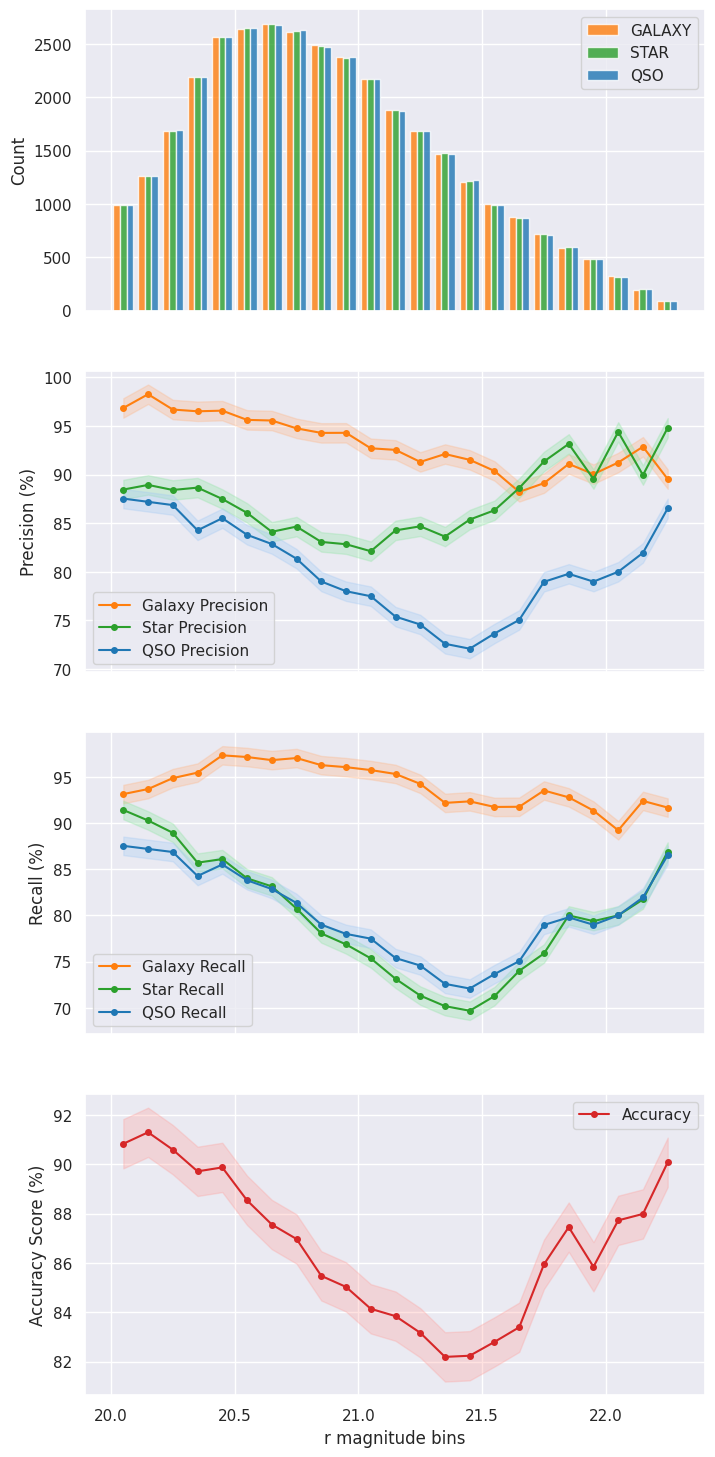

In [14]:
subdfs = pd.concat(subdflist)
subdfs["r"]=subdfs["dered_r"]+subdfs["extinction_r"]
gal_recall_list = []
gal_precision_list = []
star_recall_list = []
star_precision_list = []
qso_precision_list = []
qso_recall_list = []
for r in reportlist:
    gal_recall_list.append(r["GALAXY"]["recall"])
    gal_precision_list.append(r["GALAXY"]["precision"])
    star_recall_list.append(r["STAR"]["recall"])
    star_precision_list.append(r["STAR"]["precision"])
    qso_recall_list.append(r["QSO"]["recall"])
    qso_precision_list.append(r["QSO"]["precision"])
    
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1,sharex=True, figsize=(8,18))

galcolor = sns.color_palette("tab10")[1]
starcolor = sns.color_palette("tab10")[2]
qsocolor = sns.color_palette("tab10")[0]
acccolor = sns.color_palette("tab10")[3]
f1color = sns.color_palette("tab10")[4]

dyfit = 0.01
x_ax = lower_bin_list+bin_size/2


d1 = subdfs[subdfs["class"]=="GALAXY"]["r"]
d2 = subdfs[subdfs["class"]=="STAR"]["r"]
d3 = subdfs[subdfs["class"]=="QSO"]["r"]

ax1.hist([d1, d2, d3], color=[galcolor,starcolor, qsocolor],
         alpha=0.8, label=["GALAXY","STAR","QSO"],bins=len(lower_bin_list))
ax1.set_ylabel("Count")

ax1.legend()


y_ax1 = np.array(gal_precision_list)
y_ax2 = np.array(star_precision_list)
y_ax3 = np.array(qso_precision_list)

ax2.errorbar(x_ax, y_ax1*100,fmt="-o", ms=4, label="Galaxy Precision",color=galcolor)
ax2.fill_between(x_ax, y_ax1*100 - dyfit*100, y_ax1*100 + dyfit*100,
             color=sns.color_palette("pastel")[1], alpha=0.3)
ax2.errorbar(x_ax, y_ax2*100,fmt="-o", ms=4, label="Star Precision",color=starcolor)
ax2.fill_between(x_ax, y_ax2*100 - dyfit*100, y_ax2*100 + dyfit*100,
                 color=sns.color_palette("pastel")[2], alpha=0.3)
ax2.errorbar(x_ax, y_ax3*100,fmt="-o", ms=4, label="QSO Precision",color=qsocolor)
ax2.fill_between(x_ax, y_ax3*100 - dyfit*100, y_ax3*100 + dyfit*100,
                 color=sns.color_palette("pastel")[0], alpha=0.3)
ax2.set_ylabel("Precision (%)")
ax2.legend()

y_ax1 = np.array(gal_recall_list)
y_ax2 = np.array(star_recall_list)
y_ax3 = np.array(qso_precision_list)

ax3.errorbar(x_ax, y_ax1*100,fmt="-o", ms=4, label="Galaxy Recall",color=galcolor)
ax3.fill_between(x_ax, y_ax1*100 - dyfit*100, y_ax1*100 + dyfit*100,
             color=sns.color_palette("pastel")[1], alpha=0.3)
ax3.errorbar(x_ax, y_ax2*100,fmt="-o", ms=4, label="Star Recall",color=starcolor)
ax3.fill_between(x_ax, y_ax2*100 - dyfit*100, y_ax2*100 + dyfit*100,
             color=sns.color_palette("pastel")[2], alpha=0.3)
ax3.errorbar(x_ax, y_ax3*100,fmt="-o", ms=4, label="QSO Recall",color=qsocolor)
ax3.fill_between(x_ax, y_ax3*100 - dyfit*100, y_ax3*100 + dyfit*100,
             color=sns.color_palette("pastel")[0], alpha=0.3)
ax3.set_ylabel("Recall (%)")
ax3.legend()



y_ax1 = np.array(acclist)
y_ax2 = np.array(f1list)
ax4.errorbar(x_ax, y_ax1*100,fmt="-o", ms=4, label="Accuracy",color=acccolor)
# ax4.errorbar(x_ax, y_ax2*100,fmt="-o", ms=4, label="F1 Score",color=f1color)
ax4.fill_between(x_ax, y_ax1*100 - dyfit*100, y_ax1*100 + dyfit*100,
             color=sns.color_palette("pastel")[3], alpha=0.3)
ax4.set_ylabel("Accuracy Score (%)")
ax4.legend()

plt.xlabel("r magnitude bins")


# plt.suptitle("Star-Galaxy-QSO")
plt.savefig("Trained_Models/Experiment2/SGQ/EX2_SGQ_v2Set.pdf")
plt.show()